In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy.special import erf
import scipy.constants as constants
from astropy.table import Table, vstack

# Everything above should import with no issue, everything below needs directing
homepath = "/global/homes/c/cpopik/"
packpath = homepath+"Packages/"

import camb
sys.path.append(packpath + "hmvec/")
import hmvec as hm

sys.path.append(packpath+"ostrich/src/pality/")
import pality
sys.path.append(packpath+'ostrich/')
import ostrich
sys.path.append(packpath+"emu_CAMELS/scripts/LH_emulator/")
import helper_functions_LH as fs

# Initializing Emulator

In [2]:
home=packpath+'emu_CAMELS/emulator_profiles/LH_set/' #point to your profiles
suite='IllustrisTNG'  # Simulation suite to emulate (SIMBA, IllustrisTNG)
prof='pth_mean'  # Profile to output (rho_mean, rho_med, pth_mean, pth_med)
func_str='linear' #this is the Rbf interpolation function

samples, rs, y, emulator = fs.build_emulator_3D(home,suite,prof,func_str)

In [3]:
om=0.3
s8=0.8
asn1=0.5
agn1=1.2
asn2=0.7
agn2=1.5
m= 13
z = 0.4
params=np.array([[om,s8,asn1,agn1,asn2,agn2, z, m]])

emulated = emulator(params)

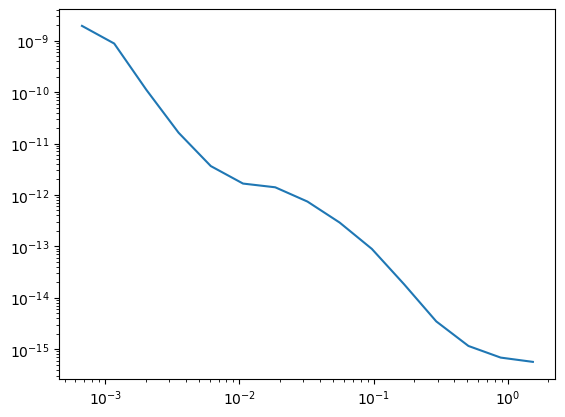

In [4]:
plt.loglog(rs, 10**emulated)

# hmvec stuff

In [72]:
# Create model
# zs = np.linspace(0, 1.5, 16)
zs = np.linspace(0, 0.55, 16)
ms = np.geomspace(10**11, 10**15, 200)  # M needs to have a big range or it's bad
ks = np.geomspace(1e-4, 100, 1001)
hcos = hm.HaloModel(zs, ks, ms=ms)

xmax = 20
nxs = 5000
hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

In [73]:
family='pres'

if family is None: family = hcos.p['battaglia_pres_family'] # AGN or SH?
pparams = {}
pparams['battaglia_pres_gamma'] = hcos.p['battaglia_pres_gamma']
pparams['battaglia_pres_alpha'] = hcos.p['battaglia_pres_alpha']
pparams.update(hm.battaglia_defaults[family])


# Convert masses to m200critz
rhocritz = hcos.rho_critical_z(hcos.zs)
if hcos.mdef=='vir':
    delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)
elif hcos.mdef=='mean':
    delta_rhos1 = hcos.rho_matter_z(hcos.zs)*200.
rvirs = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)

# Generate profiles
"""
The physical profile is rho(r) = f(2r/R200)
We rescale this to f(x), so x = r/(R200/2) = r/rgs
So rgs = R200/2 is the equivalent of rss in the NFW profile
"""
omb = hcos.p['ombh2'] / hcos.h**2.
omm = hcos.om0
presFunc = lambda x: hm.P_e_generic_x(x,m200critz[...,None],r200critz[...,None],hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                            alpha=pparams['battaglia_pres_alpha'],
                            gamma=pparams['battaglia_pres_gamma'],
                            P0_A0=pparams['P0_A0'],
                            P0_alpham=pparams['P0_alpham'],
                            P0_alphaz=pparams['P0_alphaz'],
                            xc_A0=pparams['xc_A0'],
                            xc_alpham=pparams['xc_alpham'],
                            xc_alphaz=pparams['xc_alphaz'],
                            beta_A0=pparams['beta_A0'],
                            beta_alpham=pparams['beta_alpham'],
                            beta_alphaz=pparams['beta_alphaz'])

rgs = r200critz
cgs = rvirs/rgs
sigmaT=constants.physical_constants['Thomson cross section'][0] # units m^2
mElect=constants.physical_constants['electron mass'][0] / hm.default_params['mSun']# units kg
ks,pkouts = hm.generic_profile_fft(presFunc,cgs,rgs[...,None],hcos.zs,hcos.ks,xmax,nxs,do_mass_norm=False)
pk_profile = pkouts.copy()*4*np.pi*(sigmaT/(mElect*constants.c**2))*(r200critz**3*((1+hcos.zs)**2/hcos.h_of_z(hcos.zs))[...,None])[...,None]   

# Multi redshift/mass

In [74]:
# This was a test to try to get a function that would take a multidimensional array of parameters
# Commented out b/c I don't think we need it, but kept for safekeeping

# oms = np.array([0.3])
# s8s = np.array([0.8])
# asn1s = np.array([0.5, 0.6])
# agn1s = np.array([1.2])
# asn2s = np.array([0.7, 0.8])
# agn2s = np.array([1.5])
# param_scans = np.array([oms, s8s, asn1s, agn1s, asn2s, agn2s], dtype=object)

# def emu_profiles(params, emulator):
#     oms, s8s, asn1s, agn1s, asn2s, agn2s = params
#     zs = hcos.zs
#     ms = np.log10(hcos.ms)
#     biggrid = np.meshgrid(oms, s8s, asn1s, agn1s, asn2s, agn2s, zs, ms)
#     omsgrid, s8sgrid, asn1sgrid, agn1sgrid, asn2sgrid, agn2sgrid, zsgrid, msgrid = biggrid
#     print(omsgrid.shape)
#     totalsize = oms.size*s8s.size*asn1s.size*agn1s.size*asn2s.size*agn2s.size*zs.size*ms.size
#     paramsize = oms.size*s8s.size*asn1s.size*agn1s.size*asn2s.size*agn2s.size
#     params = np.array((omsgrid, s8sgrid, asn1sgrid, agn1sgrid, asn2sgrid, agn2sgrid, zsgrid, msgrid)).T.reshape(totalsize, 8)
#     print(params[0], params[1])
#     print(emulator(params[0:3]).T)
#     profiles = 10**(emulator(params).T.reshape(paramsize, zs.size, ms.size, rs.size))
#     print(profiles.shape)
#    return profiles

In [75]:
zgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[0]
mgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[1]
blankgrid = np.ones(zgrid.shape)

def emu_profiles(params, emulator):
    om, s8, asn1, agn1, asn2, agn2 = np.array(params)
    omgrid = om*blankgrid
    s8grid = s8*blankgrid
    asn1grid = asn1*blankgrid
    agn1grid = agn1*blankgrid
    asn2grid = asn2*blankgrid
    agn2grid = agn2*blankgrid
    params = np.array((omgrid, s8grid, asn1grid, agn1grid, asn2grid, agn2grid, zgrid, mgrid)).T.reshape(hcos.zs.size*hcos.ms.size, 8)
    profiles = 10**(emulator(params).T.reshape(hcos.zs.size, hcos.ms.size, rs.size))
    return profiles

In [76]:
om=0.3
s8=0.8
asn1=0.5
agn1=1.2
asn2=0.7
agn2=1.5
params=np.array([om,s8,asn1,agn1,asn2,agn2])

unitconversion = (14/27)*(3.086e24/1.989e33)  # go from cgs to solar masses and Mpc, and P_th to P_e
Pe_emu = unitconversion*emu_profiles(params, emulator)  
# At this point we should have what is called presFunc

In [77]:
xs = np.linspace(0.,xmax,nxs+1)[1:]
xs_emu = rs[None, None, :]/rgs[:, :, None]  # dimensions should be (xdim)
rs_hm = xs[None, None, :]*rgs[:, :, None]

print(max(np.ravel(Pe_emu[:, :, 0]/presFunc(xs)[:, :, 0])), 
      min(np.ravel(Pe_emu[:, :, 0]/presFunc(xs)[:, :, 0])))

189.51444763136863 32.532728576653405


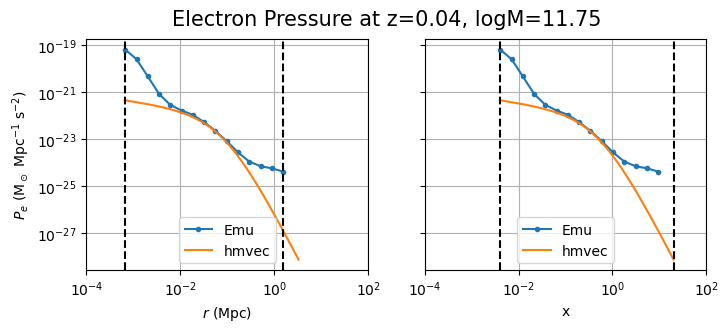

In [78]:
i, j = 1, 150

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
fig.suptitle('Electron Pressure at z='+str(np.round(hcos.zs[i], 2))+ \
                                 ', logM='+str(np.round(np.log10(hcos.ms)[j], 2)), fontsize=15)


ax1.grid(), ax1.loglog(), ax1.set_xlim(1e-4, 1e2)
ax1.plot(rs, Pe_emu[i,j], marker='.', label='Emu')
ax1.plot(rs_hm[i, j], presFunc(xs)[i, j], label='hmvec')
ax1.set_xlabel('$r$ (Mpc)', fontsize=10), ax1.set_ylabel('$P_e$ (M$_\odot$ Mpc$^{-1}$ s$^{-2}$)', fontsize=10)
ax1.axvline(rs[0], c='k', ls='--'), ax1.axvline(rs[-1], c='k', ls='--')
ax1.legend()

ax2.grid(), ax2.loglog(), ax2.set_xlim(1e-4, 1e2)
ax2.plot(xs_emu[i, j], Pe_emu[i,j], marker='.', label='Emu')
ax2.plot(xs, presFunc(xs)[i, j], label='hmvec')
ax2.set_xlabel('x', fontsize=10)
ax2.axvline(xs[0], c='k', ls='--'), ax2.axvline(xs[-1], c='k', ls='--')
ax2.legend()

plt.show()

In [79]:
xs_emu = rs[None, None, :]/rgs[:, :, None]  # dimensions should be (xdim)
rss = r200critz
rvir = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cmaxs = rvir/rss  # Dimension should be (zim, mdim)

ks_emu, profileemuhm = hm.fft.generic_profile_fft_r(Pe_emu, xs_emu, cmaxs, rss[..., None], hcos.zs, hcos.ks, do_mass_norm=False)

# At this points we should have what is called pkouts

In [80]:
unitconversion2 = 4*np.pi*(sigmaT/(mElect*constants.c**2))* \
                (r200critz**3*((1+hcos.zs)**2/hcos.h_of_z(hcos.zs))[...,None])[...,None] 

hcos.add_custom_pressure_profile(unitconversion2*profileemuhm, 'y_emu')
# This is now the y profile that is stored in hmvec

In [81]:
print(max(np.ravel(hcos.pk_profiles['y_emu']/hcos.pk_profiles['y'])), 
      min(np.ravel(hcos.pk_profiles['y_emu']/hcos.pk_profiles['y'])))

120.37896862173838 0.0


In [82]:
nfs = ((len(rs)-1)/2) * (2*np.pi/(rs[-1]-rs[0])) / (1+zs)

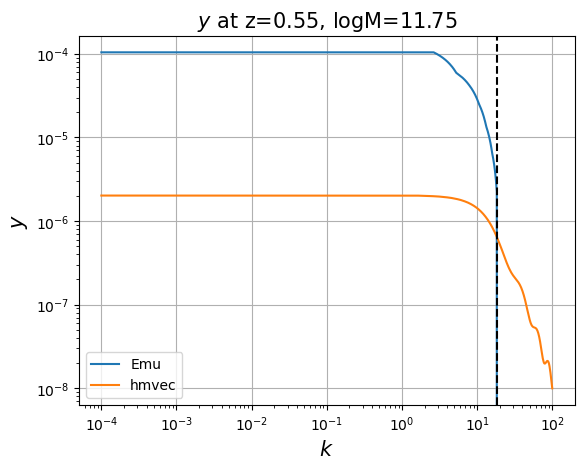

In [83]:
i, j = 15, 150

plt.title('$y$ at z='+str(np.round(hcos.zs[i], 2))+ \
                                 ', logM='+str(np.round(np.log10(hcos.ms)[j], 2)), fontsize=15)
plt.grid(), plt.loglog()
plt.plot(hcos.ks, hcos.pk_profiles['y_emu'][i,j], label='Emu')
plt.plot(hcos.ks, hcos.pk_profiles['y'][i, j], label='hmvec')
plt.xlabel('$k$', fontsize=15), plt.ylabel('$y$', fontsize=15)
plt.axvline(nfs[i], ls='--', c='k'), plt.legend()
plt.show()

In [84]:
Pyyemu = hcos.get_power('y_emu', verbose=False)
Pyy = hcos.get_power('y', verbose=False);

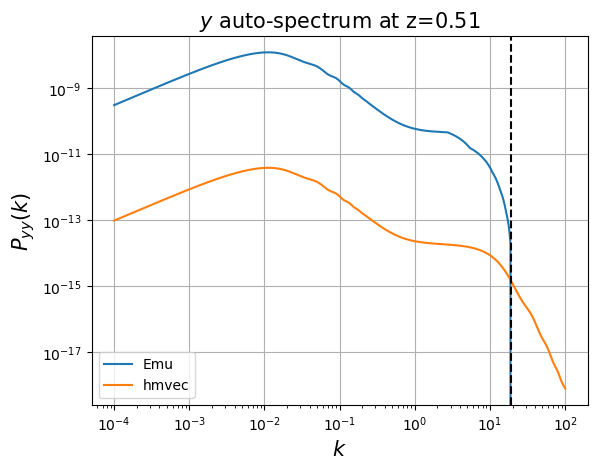

In [87]:
i = 14

plt.title('$y$ auto-spectrum at z='+str(np.round(hcos.zs[i], 2)), fontsize=15)

plt.grid(), plt.loglog()
plt.plot(hcos.ks, Pyyemu[i], label='Emu')
plt.plot(hcos.ks, Pyy[i], label='hmvec')
plt.xlabel('$k$', fontsize=15), plt.ylabel('$P_{yy} (k)$', fontsize=15)
plt.axvline(nfs[i], ls='--', c='k'), plt.legend()
plt.show()

In [39]:
zbins=np.linspace(1e-4, 1.5, 31)
gzs = zbins[:-1]+((zbins[1]-zbins[0])/2)

hcos.comoving_radial_distance(gzs) * (((len(rs)-1)/2) * (2*np.pi/(rs[-1]-rs[0])) / (1+gzs)) - (1/2)

array([ 3104.79092685,  8751.86463851, 13759.00420798, 18206.08128854,
       22160.7897492 , 25680.96525962, 28816.3706079 , 31610.08690361,
       34099.61087171, 36317.73060801, 38293.23254495, 40051.47840787,
       41614.88091698, 43003.2997416 , 44234.37393943, 45323.8032503 ,
       46285.58776604, 47132.23338394, 47874.92886934, 48523.69915938,
       49087.5386312 , 49574.52735886, 49991.93283978, 50346.29924482,
       50643.52590688, 50888.93649044, 51087.34006377, 51243.08511426,
       51360.10739758, 51441.97238688])